# かがわAIゼミナール2019
## 課題2 : Car Fuel Consumption
## 100kmあたりのガソリン消費量(consume)を予測

#### DATA:kaggle    https://www.kaggle.com/anderas/car-consume

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.svm import SVR
# 決定木
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

In [2]:
# データ読み込み
df_data_csv = pd.read_csv("./car-consume/measurements.csv") 

display(df_data_csv.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [3]:
# 最初に小数点についてドイツ形式の","から"."に変換する
# distance, consume, temp_inside, refill litters
df_data_csv['distance'] = df_data_csv['distance'].apply(lambda x: x.replace(",", ".")).astype(np.float)
df_data_csv['consume'] = df_data_csv['consume'].apply(lambda x: x.replace(",", ".")).astype(np.float)
df_data_csv['temp_inside'] = df_data_csv['temp_inside'].apply(lambda x: str(x).replace(",", ".")).astype(np.float)
df_data_csv['refill liters'] = df_data_csv['refill liters'].apply(lambda x: str(x).replace(",", ".")).astype(np.float)
df_data = df_data_csv
df_data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


#### 課題の精度基準を統一するため、最初に学習データとテストデータを作る

In [4]:
test_size = 0.2
df_y = df_data['consume']
df_X = df_data.drop('consume', axis=1)
y = df_y.values
X = df_X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

##### 目的変数
- consume : 100kmあたりの消費リッター

##### 説明変数
- distance : 距離km
- speed : 平均スピード
- temp_inside : エアコンの設定またはoffになっている場合は「Nan」
- temp_outside : 外気温
- specials : 雨、雪など気候変動がある場合は「AC」
- gas_type : 燃料のタイプ
- AC : one hot encoded, the special "AC". 1 for on, 0 for off
- rain : rain and snow is 1, good whather is 0
- refill liters : 補充燃料の量（L）
- refill gas : 補充燃料のタイプ

In [5]:
# カラム名セット
X_columns_nm = df_X.columns
y_columns_nm = ["consume"]
# DataFrameに変換
df_X_train = pd.DataFrame(X_train, columns=X_columns_nm)
df_y_train = pd.DataFrame(y_train, columns=y_columns_nm)
df_X_test = pd.DataFrame(X_test, columns=X_columns_nm)
# 学習データを再結合
df_train = df_X_train.copy()
df_train["consume"] = df_y_train["consume"]
df_train.head()

,distance,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,consume
0,16.4,49,21.5,5,NaN,E10,0,0,0,NaN,NaN,4.8
1,20,37,21.5,4,NaN,E10,0,0,0,NaN,NaN,5.2
2,12.1,33,22.5,5,NaN,SP98,0,0,0,NaN,NaN,4.4
3,25.9,43,22,24,NaN,SP98,0,0,0,NaN,NaN,4.1
4,11.8,37,20,6,NaN,SP98,0,0,0,NaN,NaN,4.3


In [6]:
# データ型を処理しやすいように、学習データを元の型に戻しておく
df_data.info()
df_train[["distance", "temp_inside", "consume", "refill liters"]] = df_train[["distance", "temp_inside", "consume", "refill liters"]].astype(np.float64)
df_train[["speed", "temp_outside", "AC", "rain", "sun"]] = df_train[["speed", "temp_outside", "AC", "rain", "sun"]].astype(np.int64)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 12 columns):
distance         310 non-null float64
speed            310 non-null int64
temp_inside      303 non-null float64
temp_outside     310 non-null int64
specials         79 non-null object
gas_type         310 non-null object
AC               310 non-null int64
rain             310 non-null 

##### まずは、gas_typeをカテゴリ変数からダミー変数（1,0）に変換する

In [7]:
# gas_typeを1:SP98, 0:E10 に変換
print(df_train['gas_type'].value_counts())
df_train['gas_type'] = np.where(df_train['gas_type'] == "SP98", 1, 0)
df_X_test['gas_type'] = np.where(df_X_test['gas_type'] == "SP98", 1, 0)

SP98    174
E10     136
Name: gas_type, dtype: int64


#### 不要な説明変数を減らす
- specials は、すでにone-hotベクトルに変換されたAC列があるため、除外
- refill gas は、gas_typeと同じため除外

In [8]:
df_train = df_train.drop(['specials','refill gas'], axis=1)
df_X_test = df_X_test.drop(['specials','refill gas'], axis=1)

### データの整理（前処理）

- 欠損値Nanチェック
- 外れ値チェック

In [9]:
# 欠損値確認
print(df_train.isnull().sum())
print('-'*40)
print(df_X_test.isnull().sum())

distance           0
speed              0
temp_inside        7
temp_outside       0
gas_type           0
AC                 0
rain               0
sun                0
refill liters    300
consume            0
dtype: int64
----------------------------------------
distance          0
speed             0
temp_inside       5
temp_outside      0
gas_type          0
AC                0
rain              0
sun               0
refill liters    75
dtype: int64


In [10]:
# refill liters（補充燃料）の欠損値を0で埋める
df_train["refill liters"] = df_train["refill liters"].fillna(0)
df_X_test["refill liters"] = df_X_test["refill liters"].fillna(0)

# temp_insideの欠損データは意味を持つ為、削除する
df_train = df_train.dropna(subset = ['temp_inside'])

In [11]:
# 燃費でソートし、全体を見てみる
df_train.sort_values('consume')

,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill liters,consume
69,25.5,27,22.0,27,1,0,0,1,0.0,3.6
231,10.5,42,20.0,10,1,0,0,0,37.7,3.6
188,18.1,36,20.0,19,1,0,0,0,0.0,3.6
168,11.9,33,25.0,19,1,0,0,0,0.0,3.7
227,16.0,44,22.0,16,1,0,0,0,0.0,3.7
162,5.5,33,24.5,28,1,0,0,1,0.0,3.7
160,16.0,39,24.5,18,1,0,0,0,0.0,3.7
251,13.6,33,24.5,28,1,0,0,1,0.0,3.7
290,16.6,49,22.0,17,0,0,0,0,37.7,3.7
22,16.0,45,22.0,17,0,0,0,0,0.0,3.7


- temp_insideは数値の幅も小さく、テストデータにNaN値もあり、temp_inside以外が同じ時にconsumeも同じであった。
  - 説明変数からtemp_insideをなくす
- distance, speed が関係しているように思える。
  - 移動時間　distance/ speed で新たな変数timeを追加してみる

In [12]:
df_train = df_train.drop(['temp_inside'], axis=1)
df_X_test = df_X_test.drop(['temp_inside'], axis=1)

In [13]:
df_train["time"] = df_train["distance"] / df_train["speed"]
df_train.head()
df_X_test["time"] = df_X_test["distance"] / df_X_test["speed"]

### 統計情報

In [14]:
df_train.head()

,distance,speed,temp_outside,gas_type,AC,rain,sun,refill liters,consume,time
0,16.4,49,5,0,0,0,0,0.0,4.8,0.334694
1,20.0,37,4,0,0,0,0,0.0,5.2,0.540541
2,12.1,33,5,1,0,0,0,0.0,4.4,0.366667
3,25.9,43,24,1,0,0,0,0.0,4.1,0.602326
4,11.8,37,6,1,0,0,0,0.0,4.3,0.318919


In [15]:
# 基本情報
display(df_train.describe())
# 相関係数を確認
display(df_train.corr())

,distance,speed,temp_outside,gas_type,AC,rain,sun,refill liters,consume,time
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,19.747195,41.590759,11.422442,0.554455,0.089109,0.135314,0.082508,1.217492,4.936634,0.452447
std,21.148351,13.439249,7.120981,0.497848,0.285372,0.342624,0.275593,6.818405,1.084697,0.307606
min,1.300000,14.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.600000,0.061905
25%,11.800000,32.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.300000,0.282321
50%,15.400000,40.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.700000,0.369565
75%,19.300000,50.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.200000,0.541323
max,211.000000,88.000000,31.000000,1.000000,1.000000,1.000000,1.000000,45.000000,12.200000,2.637500


,distance,speed,temp_outside,gas_type,AC,rain,sun,refill liters,consume,time
distance,1.000000,0.558193,0.093842,-0.068224,-0.027638,-0.071488,0.002227,0.173217,-0.163166,0.880873
speed,0.558193,1.000000,0.035409,-0.105042,-0.012045,-0.018137,-0.003370,0.012014,-0.248968,0.225609
temp_outside,0.093842,0.035409,1.000000,0.155075,0.159025,-0.202653,0.378690,-0.037730,-0.336518,0.089290
gas_type,-0.068224,-0.105042,0.155075,1.000000,0.117227,0.082839,0.051613,-0.032813,-0.027314,-0.035367
AC,-0.027638,-0.012045,0.159025,0.117227,1.000000,0.248798,0.074618,-0.055941,0.087834,-0.042470
rain,-0.071488,-0.018137,-0.202653,0.082839,0.248798,1.000000,-0.118628,0.055396,0.271731,-0.071158
sun,0.002227,-0.003370,0.378690,0.051613,0.074618,-0.118628,1.000000,-0.053635,-0.182944,0.015642
refill liters,0.173217,0.012014,-0.037730,-0.032813,-0.055941,0.055396,-0.053635,1.000000,-0.045226,0.225715
consume,-0.163166,-0.248968,-0.336518,-0.027314,0.087834,0.271731,-0.182944,-0.045226,1.000000,-0.213115
time,0.880873,0.225609,0.089290,-0.035367,-0.042470,-0.071158,0.015642,0.225715,-0.213115,1.000000


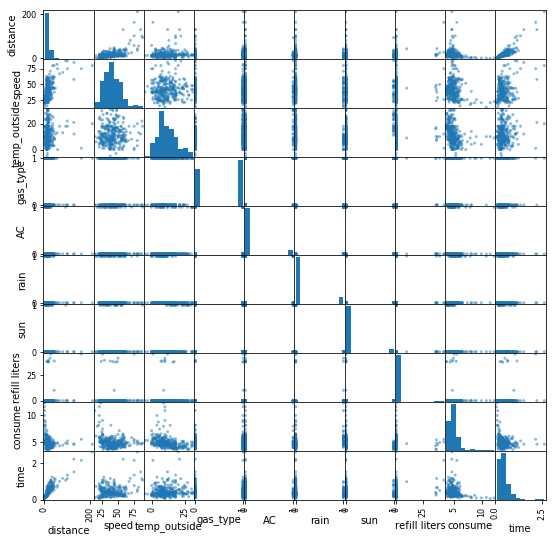

In [16]:
# 散布図行列
pd.plotting.scatter_matrix(df_train, figsize=(9,9))
plt.show()

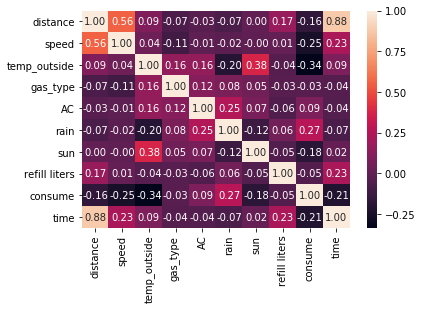

In [17]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_train.corr(), annot=True, fmt='.2f')
plt.show()

→　distance と speed に少し正の相関が見られる

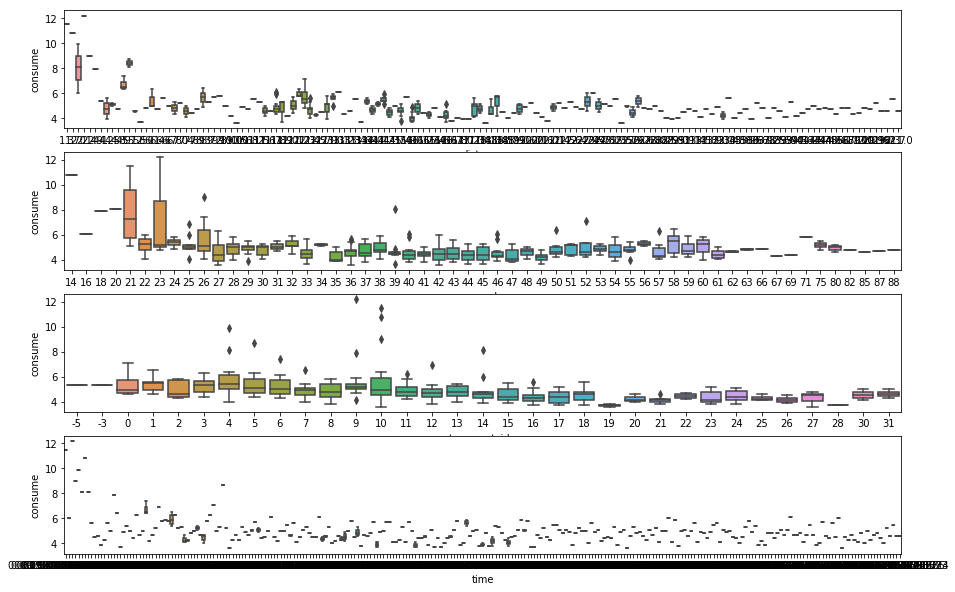

In [18]:
fig, ax = plt.subplots(4,1,figsize=(15,10))
sns.boxplot(x='distance', y='consume', data=df_train, ax=ax[0])
sns.boxplot(x='speed', y='consume', data=df_train, ax=ax[1])
sns.boxplot(x='temp_outside', y='consume', data=df_train, ax=ax[2])
# sns.boxplot(x='temp_inside', y='consume', data=df_train, ax=ax[3])
sns.boxplot(x='time', y='consume', data=df_train, ax=ax[3])

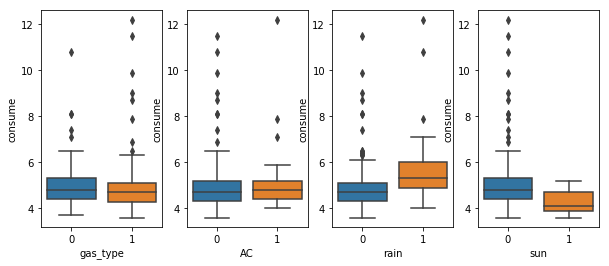

In [19]:
fig, ax = plt.subplots(1,4,figsize=(10,4))
sns.boxplot(x='gas_type', y='consume', data=df_train, ax=ax[0])
sns.boxplot(x='AC', y='consume', data=df_train, ax=ax[1])
sns.boxplot(x='rain', y='consume', data=df_train, ax=ax[2])
sns.boxplot(x='sun', y='consume', data=df_train, ax=ax[3])

→　移動距離が短かったり、平均スピードが遅かったり、雨の時に燃費が悪くなる傾向が見られる

In [20]:
df_train

,distance,speed,temp_outside,gas_type,AC,rain,sun,refill liters,consume,time
0,16.4,49,5,0,0,0,0,0.0,4.8,0.334694
1,20.0,37,4,0,0,0,0,0.0,5.2,0.540541
2,12.1,33,5,1,0,0,0,0.0,4.4,0.366667
3,25.9,43,24,1,0,0,0,0.0,4.1,0.602326
4,11.8,37,6,1,0,0,0,0.0,4.3,0.318919
5,12.4,38,-5,0,0,0,0,0.0,5.3,0.326316
6,12.2,60,11,1,0,0,0,0.0,5.8,0.203333
7,16.0,46,17,1,0,0,0,0.0,4.1,0.347826
8,29.0,27,12,1,0,0,0,0.0,4.0,1.074074
9,41.9,53,14,1,0,0,0,0.0,4.7,0.790566


#### 学習用に、前処理後の train と test を作る

In [21]:
df_X_train_1 = df_train.drop('consume', axis=1)
X_train_1 = df_X_train_1.values
X_test_1 = df_X_test.values
y_train = df_train['consume'].values

### 標準化

In [22]:
#標準化
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train_1)
X_test_std = stdsc.transform(X_test_1)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### 特徴選択

- ステップワイズ法による特徴選択

In [23]:
estimator = LinearRegression(normalize=False)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

In [24]:
# 説明変数を表示
df_X_train_1.columns

Index(['distance', 'speed', 'temp_outside', 'gas_type', 'AC', 'rain', 'sun',
       'refill liters', 'time'],
      dtype='object')

In [25]:
# fitで特徴選択を実行
rfecv.fit(X_train_std, y_train)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=1, verbose=0)

In [26]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 3 1 1 2 4 1]


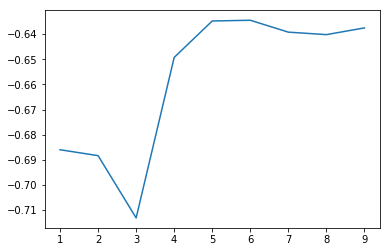

In [27]:
# 特徴数とスコアの変化をプロット
# 負のRMSEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [28]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx
# 削除してもよい特徴の名前を取得する
remove_feature = df_X_train_1.columns[remove_idx]
remove_feature

Index(['gas_type', 'sun', 'refill liters'], dtype='object')

In [29]:
# drop関数で特徴を削除
selected_train_data = df_X_train_1.drop(remove_feature, axis=1)
selected_test_data = df_X_test.drop(remove_feature, axis=1)
X_s_train = selected_train_data.values
X_s_test = selected_test_data.values

In [30]:
# 再度データの標準化
scl = StandardScaler()
X_s_train_std = scl.fit_transform(X_s_train)
X_s_test_std = scl.transform(X_s_test)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


- LASSOによる特徴選択

In [31]:
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [32]:
# fitで特徴選択を実行
sfm.fit(X_train_std, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [33]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

全てTrueとなった

In [34]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
df_X_train_1.columns[removed_idx]

Index([], dtype='object')

In [35]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([1.17650976, 0.670623  , 0.29946545, 0.03078259, 0.07296594,
       0.20578693, 0.04975221, 0.02328062, 1.06250724])

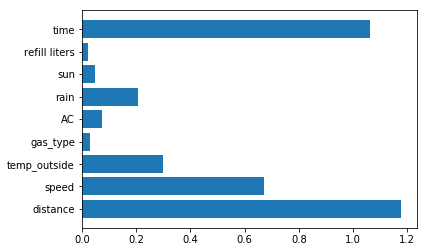

In [36]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_X_train_1.columns.values)
plt.show()

In [37]:
# ステップワイズ法を採用してみる
X_train_std = X_s_train_std
X_test_std = X_s_test_std

In [38]:
# スコアの表示
def print_rmae(_y_train,_y_pred_train, _y_test,_y_pred):
    print("学習データのスコア：")
    # 平均二乗誤差 MSEを計算
    mse = mean_squared_error(y_train, y_pred_train) 
#     print("MSE = %s"%round(mse,3) )  
    # 平方根平均二乗誤差 RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )
    # 絶対値誤差 MAEを計算
#     mae = mean_absolute_error(y_train, y_pred_train) 
#     print("MAE = %s"%round(mae,3) )
    print("テストデータのスコア：")
    mse = mean_squared_error(y_test, y_pred) 
#     print("MSE = %s"%round(mse,3) )  
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )
#     mae = mean_absolute_error(y_test, y_pred) 
#     print("MAE = %s"%round(mae,3) )

## 線形回帰モデルを使って学習

In [39]:
# 線形回帰
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train_1, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
 regr.intercept_

8.070290069669147

In [41]:
regr.coef_

array([ 0.06030637, -0.05299012, -0.04255524, -0.07097132,  0.26613454,
        0.61178863, -0.18656049, -0.00382346, -3.71679804])

In [42]:
# MSE, RMSE, MAEの確認
# 値を予測
y_pred_train = regr.predict(X_train_1)
y_pred = regr.predict(X_test_1)

In [43]:
# MSE, RMSE, MAE
print_rmae(y_train, y_pred_train,y_test, y_pred)

学習データのスコア：
RMSE = 0.867
テストデータのスコア：
RMSE = 0.853


## SVM
### クロスバリデーション

In [44]:
# サーチするパラメータのグリッド
param_grid=[{'kernel': ['rbf'], 'C':[0.001,0.01,0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1,10,100]},
                        {'kernel': ['linear'], 'C':[0.001,0.01,0.1,1,10,100]}]

In [45]:
# モデルSVR、作成したグリッド、交差検証戦略は10分割層化交差検証
#  'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
grid_search = GridSearchCV(SVR(), param_grid, cv=10)

In [46]:
# 訓練データを用いてモデル構築
grid_search.fit(X_train_std, y_train)
# ベストパラメータ
grid_search.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [47]:
y_pred_train = grid_search.predict(X_train_std)
y_pred = grid_search.predict(X_test_std)
# RMSE
print_rmae(y_train, y_pred_train,y_test, y_pred)

学習データのスコア：
RMSE = 0.648
テストデータのスコア：
RMSE = 0.614


## 決定木

In [48]:
clf_tree = DecisionTreeRegressor(random_state=1234)

In [49]:
param_grid = {"max_depth": [2,3,4,5,6], "criterion": ["mse"], "splitter":["best", "random"]}

In [50]:
tree_grid = GridSearchCV(clf_tree, param_grid = param_grid, scoring="neg_mean_squared_error", cv=10)

tree_grid.fit(X_train_1, y_train) #fit
print(tree_grid.best_params_, tree_grid.best_score_)

{'criterion': 'mse', 'max_depth': 6, 'splitter': 'random'} -0.5881435700893621


In [51]:
clf = DecisionTreeRegressor(criterion="mae", max_depth=4, splitter="random", random_state=1234)
clf = clf.fit(X_train_1, y_train)

In [52]:
y_pred_train = clf.predict(X_train_1)
y_pred = clf.predict(X_test_1)

In [53]:
# RMSE
print_rmae(y_train, y_pred_train,y_test, y_pred)

学習データのスコア：
RMSE = 0.683
テストデータのスコア：
RMSE = 0.774


## ランダムフォレスト

In [54]:
%%time
param_grid = {"max_depth":[3,5,10,None],"n_estimators":[300,400], "min_samples_leaf":[2,3]
                        , "min_samples_split":[2,3],"criterion":["mse"]}

forest_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=1234),
                                                 param_grid = param_grid, scoring="neg_mean_squared_error", cv=10, n_jobs=1)

forest_grid.fit(X_s_train, y_train)

print(forest_grid.best_params_)
print(forest_grid.best_score_)

{'criterion': 'mse', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
-0.4317888335881035
CPU times: user 1min 56s, sys: 291 ms, total: 1min 56s
Wall time: 1min 56s


In [55]:
# 最適パラメータを用いて識別する
rfr = RandomForestRegressor(**forest_grid.best_params_)
rfr.fit(X_s_train, y_train)
y_pred_train = rfr.predict(X_s_train)
y_pred = rfr.predict(X_s_test)
# RMSE
print_rmae(y_train, y_pred_train,y_test, y_pred)

学習データのスコア：
RMSE = 0.43
テストデータのスコア：
RMSE = 0.646


[0.38195277 0.08767006 0.15040617 0.00412325 0.01643191 0.35941585]


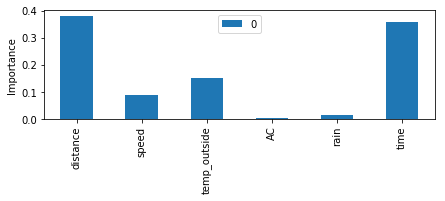

In [56]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(rfr.feature_importances_)
pd.DataFrame(rfr.feature_importances_, index=selected_train_data.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.show()

## ニューラルネットワーク

In [93]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn import KerasRegressor

def reg_model():
    model = Sequential()
    model.add(Dense(6, activation='relu', input_dim=6))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))

    # ------ 最適化手法 ------
    # sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
    # rms = RMSprop(lr=0.01)
    # adag = Adagrad(lr=0.01)
    # adad = Adadelta(lr=0.01)
    adam = Adam(lr=0.01)
    # -----------------------------

    model.compile(loss='mean_squared_error', optimizer=adam
                  ,metrics=['mean_squared_error'])
    return model

In [94]:
estimator = KerasRegressor(build_fn=reg_model, epochs=10000, batch_size=20, verbose=0)
history = estimator.fit(X_train_std, y_train)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mean_squared_error,epoch
0,18.425544,18.425544,0
1,6.116631,6.116631,1
2,2.283017,2.283017,2
3,1.077053,1.077053,3
4,0.890502,0.890502,4
5,0.774265,0.774265,5
6,0.716210,0.716210,6
7,0.685677,0.685677,7
8,0.661720,0.661720,8
9,0.683886,0.683886,9


In [95]:
y_pred_train = estimator.predict(X_train_std)
y_pred = estimator.predict(X_test_std)
# RMSE
print_rmae(y_train, y_pred_train,y_test, y_pred)

学習データのスコア：
RMSE = 0.494
テストデータのスコア：
RMSE = 0.684


→　過学習が見られる

### 結果は、RMSE＝0.614。SVMを用いた時に最も良い数値が出ました。